In [1]:
import nhd_network
import xarray as xr
from functools import partial

In [2]:
path = "al_routelink.nc"
ds = xr.open_dataset(path)

In [3]:
subslice = [
    "link",
    "to",
    "gages",
]
df = ds[subslice].to_dataframe().astype({"link": int, "to": int,})

In [4]:
df = df.set_index("link")
df

,to,gages,lat,lon,State
link,,,,,
19566408,19566406,b' ',34.745842,-87.973145,Alabama
19566410,19566412,b' ',34.719414,-87.975365,Alabama
19566416,936030090,b' ',34.715527,-87.999626,Alabama
19566418,19566412,b' ',34.715916,-87.974808,Alabama
19566422,19566404,b' ',34.725525,-87.959076,Alabama
...,...,...,...,...,...
18516130,0,b' ',30.409370,-87.863617,Alabama
18516132,0,b' ',30.389450,-87.855713,Alabama
18516148,0,b' ',30.247742,-87.937485,Alabama


In [5]:
def replace_downstreams(data, downstream_col, terminal_code):
    ds0_mask = data[downstream_col] == terminal_code
    new_data = data.copy()
    new_data.loc[ds0_mask, downstream_col] = ds0_mask.index[ds0_mask]

    # Also set negative any nodes in downstream col not in data.index
    new_data.loc[~data[downstream_col].isin(data.index), downstream_col] *= -1
    return new_data


def organize_independent_networks(connections):
    rconn = nhd_network.reverse_network(connections)
    independent_networks = nhd_network.reachable_network(rconn)
    reaches_bytw = {}
    for tw, net in independent_networks.items():
        path_func = partial(nhd_network.split_at_junction, net)
        reaches_bytw[tw] = nhd_network.dfs_decomposition(net, path_func)

    return independent_networks, reaches_bytw, rconn

In [6]:
df = df.sort_index()
df = replace_downstreams(df, "to", 0)

In [7]:
connections = nhd_network.extract_connections(df, "to")

In [8]:
independent_networks, reaches_bytw, rconn = organize_independent_networks(
    connections)

In [9]:
reachable_subnetworks = nhd_network.reachable_network(rconn)

In [10]:
def traverse(rconn, root, num_upstreams):
    num_upstreams[root] += len(rconn[root])
    for child in rconn[root]:
        traverse(rconn, child, num_upstreams)
        num_upstreams[root] += num_upstreams[child]

In [11]:
test_rconn = {
    1: [5, 6],
    2: [7],
    3: [8],
    4: [9, 10, 11],
    5: [12],
    6: [13, 14],
    7: [],
    8: [15],
    9: [16, 17, 18],
    10: [19],
    11: [],
    12: [],
    13: [20, 21], 
    14: [22],
    15: [],
    16: [23, 24, 25], 
    17: [],
    18: [26],
    19: [],
    20: [27],
    21: [],
    22: [],
    23: [],
    24: [],
    25: [],
    26: [],
    27: []
}

In [15]:
test_num_upstreams = {key: 0 for key in list(test_rconn.keys())}
roots = [1,2,3,4]

In [16]:
for root in roots:
    traverse(test_rconn, root, test_num_upstreams)

In [17]:
test_num_upstreams

{1: 9,
 2: 1,
 3: 2,
 4: 11,
 5: 1,
 6: 6,
 7: 0,
 8: 1,
 9: 7,
 10: 1,
 11: 0,
 12: 0,
 13: 3,
 14: 1,
 15: 0,
 16: 3,
 17: 0,
 18: 1,
 19: 0,
 20: 1,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0}

In [22]:
tailwaters = [x for x in list(rconn.keys()) if x < 0]
num_upstreams = {key: 0 for key in list(rconn.keys())}
for root in tailwaters:
    traverse(rconn, root, num_upstreams)

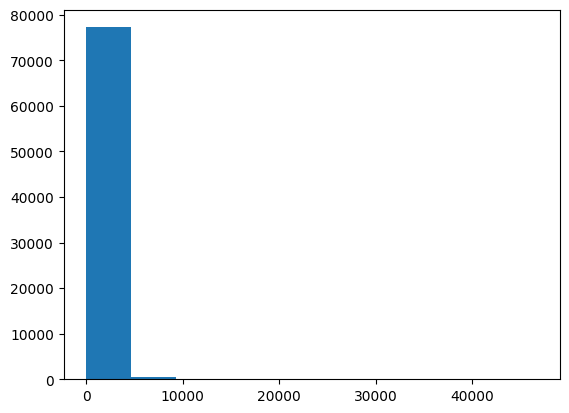

In [20]:
import matplotlib.pyplot as plt

vals = list(num_upstreams.values())
plt.hist(vals)
plt.show()

In [30]:
headwaters = [x for x in list(num_upstreams.keys()) 
              if num_upstreams[x] == 0]

In [44]:
zero_one_pairs = {headwater: connections[headwater][0] 
                  for headwater in headwaters
                  if num_upstreams[connections[headwater][0]] == 1}

In [45]:
zero_one_pairs

{445308: 445314,
 445322: 445326,
 445328: 445336,
 445330: 446390,
 445344: 445342,
 445352: 445366,
 445354: 445372,
 445376: 445388,
 445406: 445422,
 445408: 445392,
 445428: 445452,
 445430: 446266,
 445432: 446264,
 445458: 446272,
 445484: 446274,
 445486: 445498,
 445490: 445470,
 445506: 445542,
 445514: 445520,
 445516: 445524,
 445522: 446286,
 445574: 446320,
 445582: 445568,
 445588: 446314,
 445600: 445606,
 445616: 445618,
 445628: 445634,
 445640: 446356,
 445648: 446362,
 445650: 446354,
 445652: 446364,
 445718: 445722,
 445958: 446394,
 445968: 446396,
 446126: -447608,
 446138: 448666,
 446142: 450536,
 446268: 445464,
 446404: 445310,
 446406: 445320,
 446408: 445400,
 446410: 445404,
 446412: 445446,
 446414: 445696,
 446416: 445694,
 446418: 445710,
 446420: 445798,
 446422: 445878,
 446424: 445884,
 446426: 445890,
 446428: 445978,
 446430: 446036,
 446432: 446072,
 446434: 446006,
 446436: 446068,
 446438: 446064,
 446440: 446110,
 788776: 788794,
 788886: 7892

In [46]:
import json
with open('al_pairs.txt', 'w') as file:
    file.write(json.dumps(zero_one_pairs))